In [1]:
# Husayn El Sharif
comment = """

use efficientnet from tensorhub and force 456 x 456 size
"""

In [2]:
# TensorFlow Import and GPU Check

import tensorflow as tf
import tf_keras as keras # Import tf_keras for Keras 3 compatibility
import tensorflow_hub as hub
print("TF Version:", tf.__version__)
print("TF Hub Version:", hub.__version__)

# Check if GPU is savailable
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        print(f"- {gpu}")
else:
    print("No GPUs found.")

I0000 00:00:1763059156.715938    4710 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1763059156.754653    4710 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1763059158.424448    4710 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/helsharif/miniconda3/envs/env003/lib/python3.11/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is depre

TF Version: 2.21.0-dev20251107
TF Hub Version: 0.17.0.dev
GPUs available:
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# other imports
import numpy as np
import pandas as pd
import os
import glob

import datetime


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


from IPython.display import Image

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots




import datetime



In [4]:
# Use filenames and folders to get filepath and labels for all images
all_imagefiles_list = glob.glob('eye_disease_data_resized/dataset/**/*.jpg') # this data was batch resized to 456 x 456 and resaved to .jpg using Corel Pro Photo 2019
all_imagefiles_list

labels_temp = [filepath.split('/')[-2] for filepath in all_imagefiles_list]


In [5]:
# create dataframe with image_filepath, label
full_data_df = pd.DataFrame({
    'image_filepath': all_imagefiles_list,
    'label': labels_temp,
})
full_data_df

image_filepath     label
0     eye_disease_data_resized/dataset/cataract/0_le...  cataract
1     eye_disease_data_resized/dataset/cataract/103_...  cataract
2     eye_disease_data_resized/dataset/cataract/1062...  cataract
3     eye_disease_data_resized/dataset/cataract/1083...  cataract
4     eye_disease_data_resized/dataset/cataract/1084...  cataract
...                                                 ...       ...
4011  eye_disease_data_resized/dataset/normal/8_righ...    normal
4012  eye_disease_data_resized/dataset/normal/939_le...    normal
4013  eye_disease_data_resized/dataset/normal/939_ri...    normal
4014  eye_disease_data_resized/dataset/normal/951_le...    normal
4015  eye_disease_data_resized/dataset/normal/951_ri...    normal

[4016 rows x 2 columns]

In [6]:
# how many images of each label?
print(full_data_df["label"].value_counts())

comment = """
Classess appear roughly balanced in quantity
"""

label
diabetic_retinopathy    1098
normal                  1074
cataract                 938
glaucoma                 906
Name: count, dtype: int64


In [7]:
# randomly shuffle rows (without replacement) of full_data_df

full_data_df_shuffled = full_data_df.sample(frac=1, random_state=42, ignore_index=True, replace=False)
full_data_df_shuffled

image_filepath                 label
0     eye_disease_data_resized/dataset/diabetic_reti...  diabetic_retinopathy
1     eye_disease_data_resized/dataset/diabetic_reti...  diabetic_retinopathy
2     eye_disease_data_resized/dataset/glaucoma/_324...              glaucoma
3     eye_disease_data_resized/dataset/diabetic_reti...  diabetic_retinopathy
4     eye_disease_data_resized/dataset/normal/3113_l...                normal
...                                                 ...                   ...
4011  eye_disease_data_resized/dataset/diabetic_reti...  diabetic_retinopathy
4012  eye_disease_data_resized/dataset/diabetic_reti...  diabetic_retinopathy
4013  eye_disease_data_resized/dataset/cataract/_57_...              cataract
4014  eye_disease_data_resized/dataset/normal/2907_r...                normal
4015  eye_disease_data_resized/dataset/normal/2572_l...                normal

[4016 rows x 2 columns]

In [8]:
# Create boolean class labels (for shuffled data)
labels = full_data_df_shuffled['label'].values.tolist()
unique_labels = np.unique(labels) # ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
boolean_labels = [label == unique_labels for label in labels]

# Turn boolean arrays into integers
boolean_labels_integers = [bool_array.astype(int) for bool_array in boolean_labels]

In [9]:
# create our own validation data
# setup X and y variables

X = full_data_df_shuffled["image_filepath"].to_list()
y = boolean_labels_integers

In [10]:
# Set number of images to use for training + validation 
NUM_IMAGES = 3200

In [11]:
# split into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

# create 'test' data, never to be seen by model during training/fitting, by using leftover images [NUM_IMAGES:]
X_test = X[NUM_IMAGES:]
y_test = y[NUM_IMAGES:]

In [12]:
# check lengths of split data
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(2560, 2560, 640, 640, 816, 816)

In [13]:
# parameter: image size (assuming square image size)

# parameter: image size 
IMG_SIZE_HEIGHT = 456 # recommended image size for EfficientNetB5
IMG_SIZE_WIDTH = 456

In [14]:
# turn data into Tensors
# labels are already in numeric format
# so we need to process the images

# preprocessing images: turning images into tensors
# create helpful functions for pre-processing

comment = '''

1. take an image filepath as input
2. use TF to read the file and savite it to a variable, "image"
3. turn our "image" into a tensors
4. Normalize range of image channels from 0-255 to 0 - 1 (normalization)
5. resize images to be the same dimensions/size, namely shape (224, 224) for this project
6. return the modified image

helpful resources: 
https://www.tensorflow.org/guide/data
https://www.tensorflow.org/tutorials/load_data/images
'''
def process_image(image_path, img_height=IMG_SIZE_HEIGHT, img_width=IMG_SIZE_WIDTH ):
    '''
    Takes an image file path and turns image into a Tensor
    '''

    # read image file (from TF load images documentation)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)


    # Ensure square via padding before resize to avoid aspect distortion
    h = tf.shape(image)[0]
    w = tf.shape(image)[1]
    side = tf.maximum(h, w)
    image = tf.image.pad_to_bounding_box(image, (side - h)//2, (side - w)//2, side, side)
    

    
    # convert color channels from 0-255 to 0-1 values (Normalization)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # resize image
    image = tf.image.resize(image, size=[img_height, img_width], method=tf.image.ResizeMethod.AREA)
    # return image converted to tensor
    return image


In [15]:
# turining our data into batches
comment = '''
Why turn our data into batches?
Speeds up processing compared to trying to process all 10,000+ images in one go. All those images will probably not fit into RAM or VRAM (GPU)
Batch size of 32 is recommended. So process 32 images at a time

To use TF, data needs to be in the form of a Tensor tuples which look like:
(image, label)
'''

# function to return a tuple (image, label)

def get_image_label(image_path, label, img_height=IMG_SIZE_HEIGHT, img_width=IMG_SIZE_WIDTH):
    '''
    Takes image file path name and its label,
    processes the images and retunrs a tuple of (image, label)
    '''
    image = process_image(image_path, img_height=img_height, img_width=img_width)
    return image, label

In [16]:
# turn all our data, X and y, into batches of size 32
comment = '''

'''

# define batch size
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, shuffle=False):
    '''
    Creates batches of data out of image X and label y pairs
    shuffles the data if its training data (precautionary measure)
    doesn't shuffle if it's validation data
    Also accepts test data as input (no labels)
    '''

    if shuffle == False:
        # do not shuffle data
        if y is None:
            print('Creating data batches, no y labels provided...') # test data
            data = tf.data.Dataset.from_tensor_slices( tf.constant(X) ) # only filepaths, no labels
            data_batch = data.map(process_image).batch(batch_size)
        else: # if y labels provided
            print('Creating data batches, y labels provided...') # validation data
            data = tf.data.Dataset.from_tensor_slices( (tf.constant(X), tf.constant(y, dtype=tf.float32)) ) # filepaths, labels
            data_batch = data.map(get_image_label).batch(batch_size)
    else:
        # do shuffle data
        if y is None:
            print('Creating data batches, no y labels provided. Shuffling data...') # ? no need to shuffle non-training data that has no labels provided
            data = tf.data.Dataset.from_tensor_slices( tf.constant(X) ) # only filepaths, no labels
            # shuffle all the data
            data = data.shuffle(buffer_size=len(X))
            data_batch = data.map(process_image).batch(batch_size)
        else: # if y labels provided
            print('Creating data batches, y labels provided. Shuffling data...') # training data
            data = tf.data.Dataset.from_tensor_slices( (tf.constant(X), tf.constant(y, dtype=tf.float32)) ) # filepaths, labels
            # shuffle all the data
            data = data.shuffle(buffer_size=len(X)) 
            # create (image, label) tuples
            data_batch = data.map(get_image_label).batch(batch_size)

    return data_batch

In [17]:
# create training and validation data batches
# shuffle training data just in case there is spurious structure in the ordering of the data that may adversely affect model training
train_data = create_data_batches(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)

Creating data batches, y labels provided. Shuffling data...


I0000 00:00:1763059163.134208    4710 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [18]:
# create validation data batches
val_data = create_data_batches(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False) # no need to shuffle validation data

Creating data batches, y labels provided...


In [19]:
# create test data batches
test_data = create_data_batches(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False) # no need to shuffle test data

Creating data batches, y labels provided...


In [20]:
# check attriubutes of our data batches
train_data.element_spec, val_data.element_spec, test_data.element_spec

((TensorSpec(shape=(None, 456, 456, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 456, 456, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 456, 456, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))

In [21]:
# pick a model from TensorFlow Hub that suits our problem (transfer learning)
comments = '''
Before we build a model, there are a few things we need to define
1. the input shape (in the form of tensors) to our model
2. the output shape (in the form of tensors) of our model
3. the URL of the model we want to use
'''

# setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, 3] #[Batch, Height, Width, Color_Channels]

# output shape
OUTPUT_SHAPE = len(unique_labels) # an array of unique classification labels

# Setup model URL from TensorFlow Hub. See: https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b5-feature-vector/1
MODEL_URL = 'https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b5-feature-vector/1'

In [22]:
# Put it all together into a keras deep-learning model!
# use the TF keras API. Keras is a user friendly high level API for building tensorflow models
comment = '''
create function that takes input of 
input shape
output shape
model

Function defines layers in sequential fashion, compiles model, builds model, returns the model

see: https://www.tensorflow.org/guide/keras/overview
'''

def create_model( input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    print("Building model with: ".format(model_url))

    # setup model layers
    model = keras.Sequential([
            hub.KerasLayer(model_url), # Layer 1 (input layer)
            keras.layers.Dense(units = output_shape, activation="softmax"), # Layer 2 (output layer), for multi-class classficiation use softmax activation       
        ])

    # compile model
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(), # for multi-class classficiation use CategoricalCrossentropy
        optimizer = keras.optimizers.Adam(),
        metrics=[
            "accuracy", # Fraction of correct predictions.
            keras.metrics.Precision(name="prec_cataract", class_id=0), # how many predicted positives were correct. [0:'cataract', 1:'diabetic_retinopathy', 2:'glaucoma', 3:'normal']
            keras.metrics.Precision(name="prec_diab_ret", class_id=1), 
            keras.metrics.Precision(name="prec_glauc", class_id=2), 
            keras.metrics.Precision(name="prec_normal", class_id=3), 
            keras.metrics.Recall(name="recall_cataract", class_id=0), # out of all the true positives, how many were captured
            keras.metrics.Recall(name="recall_diab_ret", class_id=1), 
            keras.metrics.Recall(name="recall_glauc", class_id=2), 
            keras.metrics.Recall(name="recall_normal", class_id=3), 
            keras.metrics.F1Score(name='f1_score', threshold=None, average="macro"), # harmonic mean of precision and recall. 'macro' treats all classes equally, regardless of their size, and can be valuable when performance across all classes is equally important.
        ]
    )

    # build model
    model.build(input_shape)

    return model

In [23]:
# Create model and display summary
model = create_model( input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL )
model.summary()

Building model with: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              28513520  
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 28521716 (108.80 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 28513520 (108.77 MB)
_________________________________________________________________


In [24]:
# create callbacks: helper functions a model can use during training to save progress, check progress, or stop training early if model does not improve
# see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
comment = '''
'''

# tensorboard
%load_ext tensorboard

In [25]:
# create function to build a tensorboard callback
def create_tensorboard_callback():
    logdir = os.path.join("logs/",datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    return keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
# create function to stop training if it is not improving significantly anymore. Early stopping. See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)


In [27]:
# model checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath= os.path.join("saved_models/",datetime.datetime.now().strftime('%Y%m%d-%H%M%S'),'best_model.keras'), 
    save_weights_only=False, # Set to True if you only want to save weights
    monitor='val_accuracy', # Metric to monitor (e.g., 'val_accuracy', 'val_loss')
    mode='max', # 'min' for loss, 'max' for accuracy
    save_best_only=True,
)

In [28]:
# training a model on a subset of data (only 1000 images to make sure program works before training on 10,000+ images)
#NUM_EPOCHS = 10
NUM_EPOCHS = 50

In [29]:
# Train and return a trained model

def train_model():
    '''
    Trains a model and returns the trained version
    '''
    # create model
    model = create_model()

    # create new tensorboard session everytime we train a model
    tensorboard_callback = create_tensorboard_callback()

    # fit model, also passing it the callbacks
    model.fit(
        x=train_data, 
        epochs=NUM_EPOCHS,
        validation_data = val_data,
        validation_freq = 1,
        callbacks = [tensorboard_callback, early_stopping_callback, model_checkpoint_callback],
    )

    # return fitted model
    return model

In [30]:
# Fit model to data
model = train_model()

Building model with: 
Epoch 1/50


I0000 00:00:1763059194.906614    4796 cuda_dnn.cc:463] Loaded cuDNN version 91500
I0000 00:00:1763059196.178669    4786 service.cc:158] XLA service 0x7c3dfc194a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763059196.178698    4786 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
I0000 00:00:1763059196.183530    4786 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763059196.267910    4786 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 [==============================] - 89s 929ms/step - loss: 0.7194 - accuracy: 0.7402 - prec_cataract: 0.8944 - prec_diab_ret: 0.9642 - prec_glauc: 0.8248 - prec_normal: 0.7828 - recall_cataract: 0.6781 - recall_diab_ret: 0.6442 - recall_glauc: 0.3930 - recall_normal: 0.4683 - f1_score: 0.7337 - val_loss: 0.5205 - val_accuracy: 0.8141 - val_prec_cataract: 0.9214 - val_prec_diab_ret: 0.9853 - val_prec_glauc: 0.8977 - val_prec_normal: 0.6991 - val_recall_cataract: 0.8323 - val_recall_diab_ret: 0.8171 - val_recall_glauc: 0.5130 - val_recall_normal: 0.9042 - val_f1_score: 0.8106
Epoch 2/50
80/80 [==============================] - 137s 2s/step - loss: 0.4410 - accuracy: 0.8457 - prec_cataract: 0.9048 - prec_diab_ret: 0.9625 - prec_glauc: 0.8221 - prec_normal: 0.8090 - recall_cataract: 0.8382 - recall_diab_ret: 0.8664 - recall_glauc: 0.6591 - recall_normal: 0.8127 - f1_score: 0.8414 - val_loss: 0.4503 - val_accuracy: 0.8344 - val_prec_cataract: 0.9085 - val_prec_diab_ret: 0.9929 - val_pr

In [31]:
# Load Best Model
search_pattern = 'saved_models/**/best_model.keras'
list_of_files = glob.glob(search_pattern, recursive=True)

if not list_of_files:
    print("No file named 'best_model.keras' found in 'saved_models' subfolders.")
else:
    # Find the file with the maximum creation time (os.path.getctime)
    # or modification time (os.path.getmtime)
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f"The latest created file is: {latest_file}")


The latest created file is: saved_models/20251113-133932/best_model.keras


In [32]:
# try loading the best model
# note, need to add custom_objects={"KerasLayer":hub.KerasLayer} because of using TensorHub
loaded_best_model = keras.models.load_model(latest_file, custom_objects={"KerasLayer":hub.KerasLayer})

In [33]:
# View TensorBoard
%tensorboard --logdir logs

In [59]:
# Evaluation metrics on Train, Validation, and Test data
metric_names = ["Loss", "Accuracy", "prec_cataract", "prec_diab_ret", "prec_glauc", "prec_normal", "recall_cataract", "recall_diab_ret", "recall_glauc", "recall_normal", "F1_Score"]

In [63]:
# -----------------------
# Evaluate Train Metrics
# -----------------------
train_metrics = loaded_best_model.evaluate(train_data, verbose=0);

train_metrics_df = pd.DataFrame({
    "Metric_Name": metric_names,
    "Value": train_metrics,
})

train_metrics_df

Metric_Name     Value
0              Loss  0.269882
1          Accuracy  0.909766
2     prec_cataract  0.931667
3     prec_diab_ret  0.985935
4        prec_glauc  0.860037
5       prec_normal  0.911290
6   recall_cataract  0.913399
7   recall_diab_ret  0.985935
8      recall_glauc  0.812174
9     recall_normal  0.853474
10         F1_Score  0.906151

In [64]:
# -----------------------
# Evaluate Validation Metrics
# -----------------------

val_metrics = loaded_best_model.evaluate(val_data, verbose=0);

val_metrics_df = pd.DataFrame({
    "Metric_Name": metric_names,
    "Value": val_metrics,
})

val_metrics_df

Metric_Name     Value
0              Loss  0.300658
1          Accuracy  0.901563
2     prec_cataract  0.946309
3     prec_diab_ret  0.987805
4        prec_glauc  0.863636
5       prec_normal  0.847059
6   recall_cataract  0.909677
7   recall_diab_ret  0.987805
8      recall_glauc  0.740260
9     recall_normal  0.862275
10         F1_Score  0.900335

In [65]:
# -----------------------
# Evaluate Test Metrics
# -----------------------

test_metrics = loaded_best_model.evaluate(test_data, verbose=0);

test_metrics_df = pd.DataFrame({
    "Metric_Name": metric_names,
    "Value": test_metrics,
})

test_metrics_df

Metric_Name     Value
0              Loss  0.330488
1          Accuracy  0.887255
2     prec_cataract  0.910180
3     prec_diab_ret  0.972727
4        prec_glauc  0.816092
5       prec_normal  0.886463
6   recall_cataract  0.888889
7   recall_diab_ret  0.959641
8      recall_glauc  0.802260
9     recall_normal  0.828571
10         F1_Score  0.883982

In [37]:
# Now predict at scale with visualization of images

# turn probabilities into their respective label (for ease of understanding)

def get_pred_label(prediction_probs):
    '''
    turns an array of probabilities into a label
    '''
    return unique_labels[np.argmax(prediction_probs)]

In [38]:
# predicttions

train_data_predictions = loaded_best_model.predict(train_data, verbose=1)
val_data_predictions = loaded_best_model.predict(val_data, verbose=1)
test_data_predictions = loaded_best_model.predict(test_data, verbose=1)

26/26 [==============================] - 16s 634ms/step


In [39]:
# need to unbatch the train_data to get the predictions, images and true labels
train_data_images_unbatched_list = []
train_data_labels_unbatched_list = []

# loop through unbatched data
for image, label in train_data.unbatch().as_numpy_iterator():
    train_data_images_unbatched_list.append(image)
    train_data_labels_unbatched_list.append(label)

I0000 00:00:1763061754.565599    4710 local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [40]:
# need to unbatch the val_data to get the predictions, images and true labels
val_data_images_unbatched_list = []
val_data_labels_unbatched_list = []

# loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
    val_data_images_unbatched_list.append(image)
    val_data_labels_unbatched_list.append(label)

I0000 00:00:1763061755.510016    4710 local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
# need to unbatch the test_data to get the predictions, images and true labels
test_data_images_unbatched_list = []
test_data_labels_unbatched_list = []

# loop through unbatched data
for image, label in test_data.unbatch().as_numpy_iterator():
    test_data_images_unbatched_list.append(image)
    test_data_labels_unbatched_list.append(label)

In [42]:
train_data_unbatched_label = [get_pred_label(label) for label in train_data_labels_unbatched_list] # true label of validation data
train_predictions_label = [get_pred_label(label) for label in train_data_predictions] # prediction on validation data

In [43]:
val_data_unbatched_label = [get_pred_label(label) for label in val_data_labels_unbatched_list] # true label of validation data
val_predictions_label = [get_pred_label(label) for label in val_data_predictions] # prediction on validation data

In [44]:
test_data_unbatched_label = [get_pred_label(label) for label in test_data_labels_unbatched_list] # true label of validation data
test_predictions_label = [get_pred_label(label) for label in test_data_predictions] # prediction on validation data

In [45]:
# create dataframes

Train_Results_df = pd.DataFrame(
    {
        'True_Label': train_data_unbatched_label,
        'Prediction_Label': train_predictions_label,
        'Image_Data': train_data_images_unbatched_list,
    }
)


Validation_Results_df = pd.DataFrame(
    {
        'True_Label': val_data_unbatched_label,
        'Prediction_Label': val_predictions_label,
        'Image_Data': val_data_images_unbatched_list,
    }
)

Test_Results_df = pd.DataFrame(
    {
        'True_Label': test_data_unbatched_label,
        'Prediction_Label': test_predictions_label,
        'Image_Data': test_data_images_unbatched_list,
    }
)

In [46]:
# show some rows of dataframe
Train_Results_df[['True_Label', 'Prediction_Label']]

True_Label      Prediction_Label
0        normal              glaucoma
1        normal  diabetic_retinopathy
2        normal                normal
3      glaucoma              glaucoma
4        normal              cataract
...         ...                   ...
2555   cataract              cataract
2556     normal              glaucoma
2557   cataract              cataract
2558   glaucoma              cataract
2559   cataract  diabetic_retinopathy

[2560 rows x 2 columns]

In [47]:
# show some rows of dataframe
Validation_Results_df[['True_Label', 'Prediction_Label']]

True_Label      Prediction_Label
0    diabetic_retinopathy  diabetic_retinopathy
1    diabetic_retinopathy  diabetic_retinopathy
2                cataract              cataract
3                cataract              cataract
4    diabetic_retinopathy  diabetic_retinopathy
..                    ...                   ...
635                normal                normal
636                normal                normal
637              glaucoma              glaucoma
638              glaucoma              glaucoma
639                normal                normal

[640 rows x 2 columns]

In [48]:
# show some rows of dataframe
Test_Results_df[['True_Label', 'Prediction_Label']]

True_Label      Prediction_Label
0                  normal                normal
1                glaucoma              glaucoma
2    diabetic_retinopathy  diabetic_retinopathy
3                glaucoma              glaucoma
4                  normal                normal
..                    ...                   ...
811  diabetic_retinopathy  diabetic_retinopathy
812  diabetic_retinopathy  diabetic_retinopathy
813              cataract              cataract
814                normal                normal
815                normal                normal

[816 rows x 2 columns]

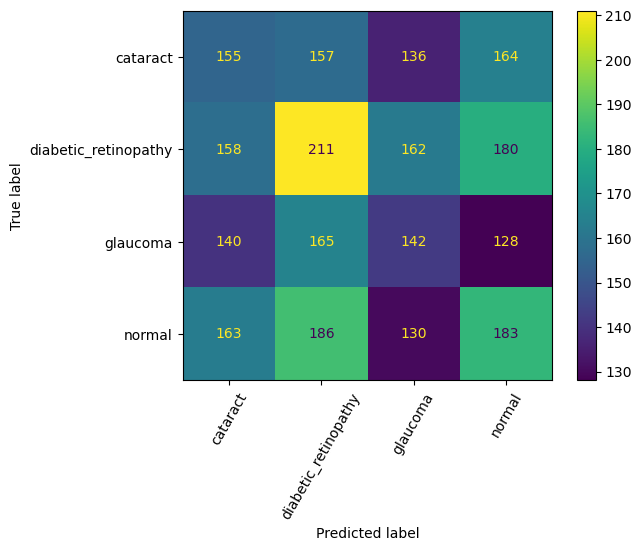

In [49]:
# Training Confusion Matrix

train_cm = confusion_matrix(Train_Results_df['True_Label'], Train_Results_df['Prediction_Label'])

disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=unique_labels)

disp.plot(xticks_rotation=60)



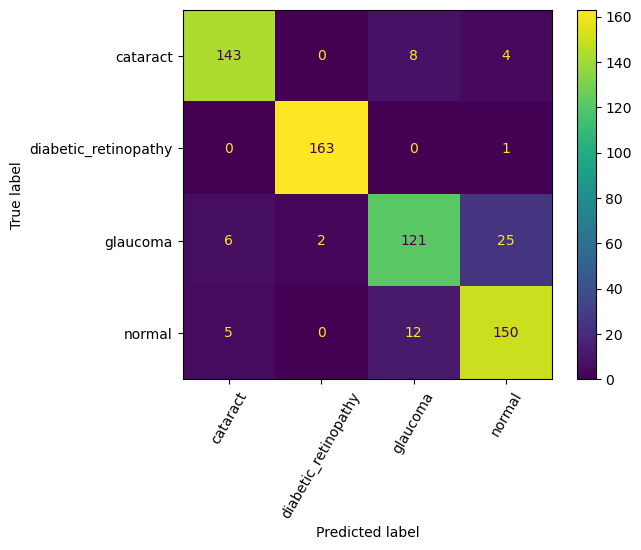

In [50]:
# Validation Confusion Matrix

val_cm = confusion_matrix(Validation_Results_df['True_Label'], Validation_Results_df['Prediction_Label'])

disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=unique_labels)

disp.plot(xticks_rotation=60)

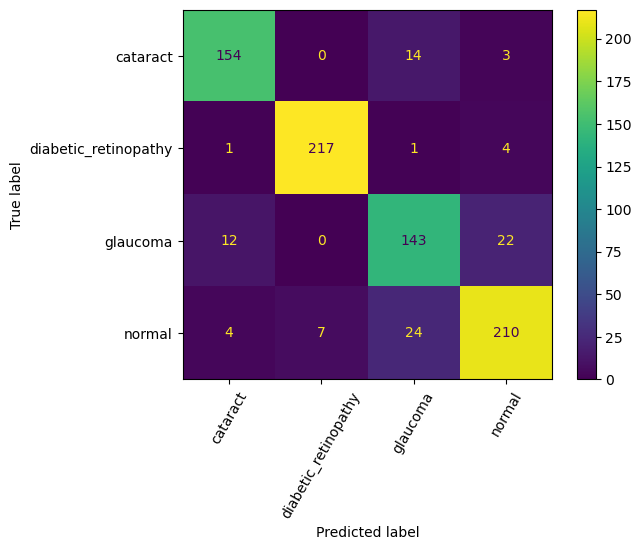

In [51]:
# Test Confusion Matrix

test_cm = confusion_matrix(Test_Results_df['True_Label'], Test_Results_df['Prediction_Label'])

disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=unique_labels)

disp.plot(xticks_rotation=60)

In [52]:
# Train Classification Report

train_report = classification_report(Train_Results_df['True_Label'], Train_Results_df['Prediction_Label'])
print(train_report)

                      precision    recall  f1-score   support

            cataract       0.25      0.25      0.25       612
diabetic_retinopathy       0.29      0.30      0.30       711
            glaucoma       0.25      0.25      0.25       575
              normal       0.28      0.28      0.28       662

            accuracy                           0.27      2560
           macro avg       0.27      0.27      0.27      2560
        weighted avg       0.27      0.27      0.27      2560



In [53]:
# Validation Classification Report

val_report = classification_report(Validation_Results_df['True_Label'], Validation_Results_df['Prediction_Label'])
print(val_report)

                      precision    recall  f1-score   support

            cataract       0.93      0.92      0.93       155
diabetic_retinopathy       0.99      0.99      0.99       164
            glaucoma       0.86      0.79      0.82       154
              normal       0.83      0.90      0.86       167

            accuracy                           0.90       640
           macro avg       0.90      0.90      0.90       640
        weighted avg       0.90      0.90      0.90       640



In [54]:
# Test Classification Report

test_report = classification_report(Test_Results_df['True_Label'], Test_Results_df['Prediction_Label'])
print(test_report)

                      precision    recall  f1-score   support

            cataract       0.90      0.90      0.90       171
diabetic_retinopathy       0.97      0.97      0.97       223
            glaucoma       0.79      0.81      0.80       177
              normal       0.88      0.86      0.87       245

            accuracy                           0.89       816
           macro avg       0.88      0.88      0.88       816
        weighted avg       0.89      0.89      0.89       816



In [55]:

# # Figures Test Results (Plotly)

# num_rows = np.ceil(np.sqrt(len(Test_Results_df))).astype(int)
# num_cols = num_rows

# df = Test_Results_df.head(100)  # shorthand, first 100 rows
# n = len(df)
# grid = int(np.ceil(np.sqrt(n)))

# # Create list of subplot titles
# titles = [
#     f"True Label: {row['True_Label']}<br>Predicted: {row['Prediction_Label']}"
#     for _, row in df.iterrows()
# ]

# # create figure
# fig = make_subplots(rows=grid, cols=grid, subplot_titles=titles, vertical_spacing=0.02, horizontal_spacing=0.01)



# def to_uint8(img):
#     """Ensure image is uint8 RGB for Plotly."""
#     arr = np.asarray(img)
#     if arr.dtype == np.uint8:
#         return arr
#     # If floats in [0,1], scale up; otherwise clip to [0,255]
#     if np.issubdtype(arr.dtype, np.floating) and arr.max() <= 1.0:
#         arr = (np.clip(arr, 0.0, 1.0) * 255).astype(np.uint8)
#     else:
#         arr = np.clip(arr, 0, 255).astype(np.uint8)
#     return arr

# for idx, img in enumerate(df["Image_Data"]):
#     r = idx // grid + 1
#     c = idx % grid + 1
#     img_u8 = to_uint8(img)            # expects shape (H, W, 3)
#     fig.add_trace(go.Image(z=img_u8), row=r, col=c)

# # Hide ticks/axes and keep a nice square layout
# fig.update_xaxes(visible=False)
# fig.update_yaxes(visible=False)

# # Optional: make figure size scale with grid
# fig.update_layout(
#     showlegend=False,
#     #margin=dict(l=10, r=10, t=10, b=10),
#     height=grid * 200,
#     width=grid * 200,
#     font=dict(size=2)
# )

# # Update the font size of all annotations (subplot titles)
# fig.update_annotations(font_size=12) # Change 12 to your desired font size

# fig.show()



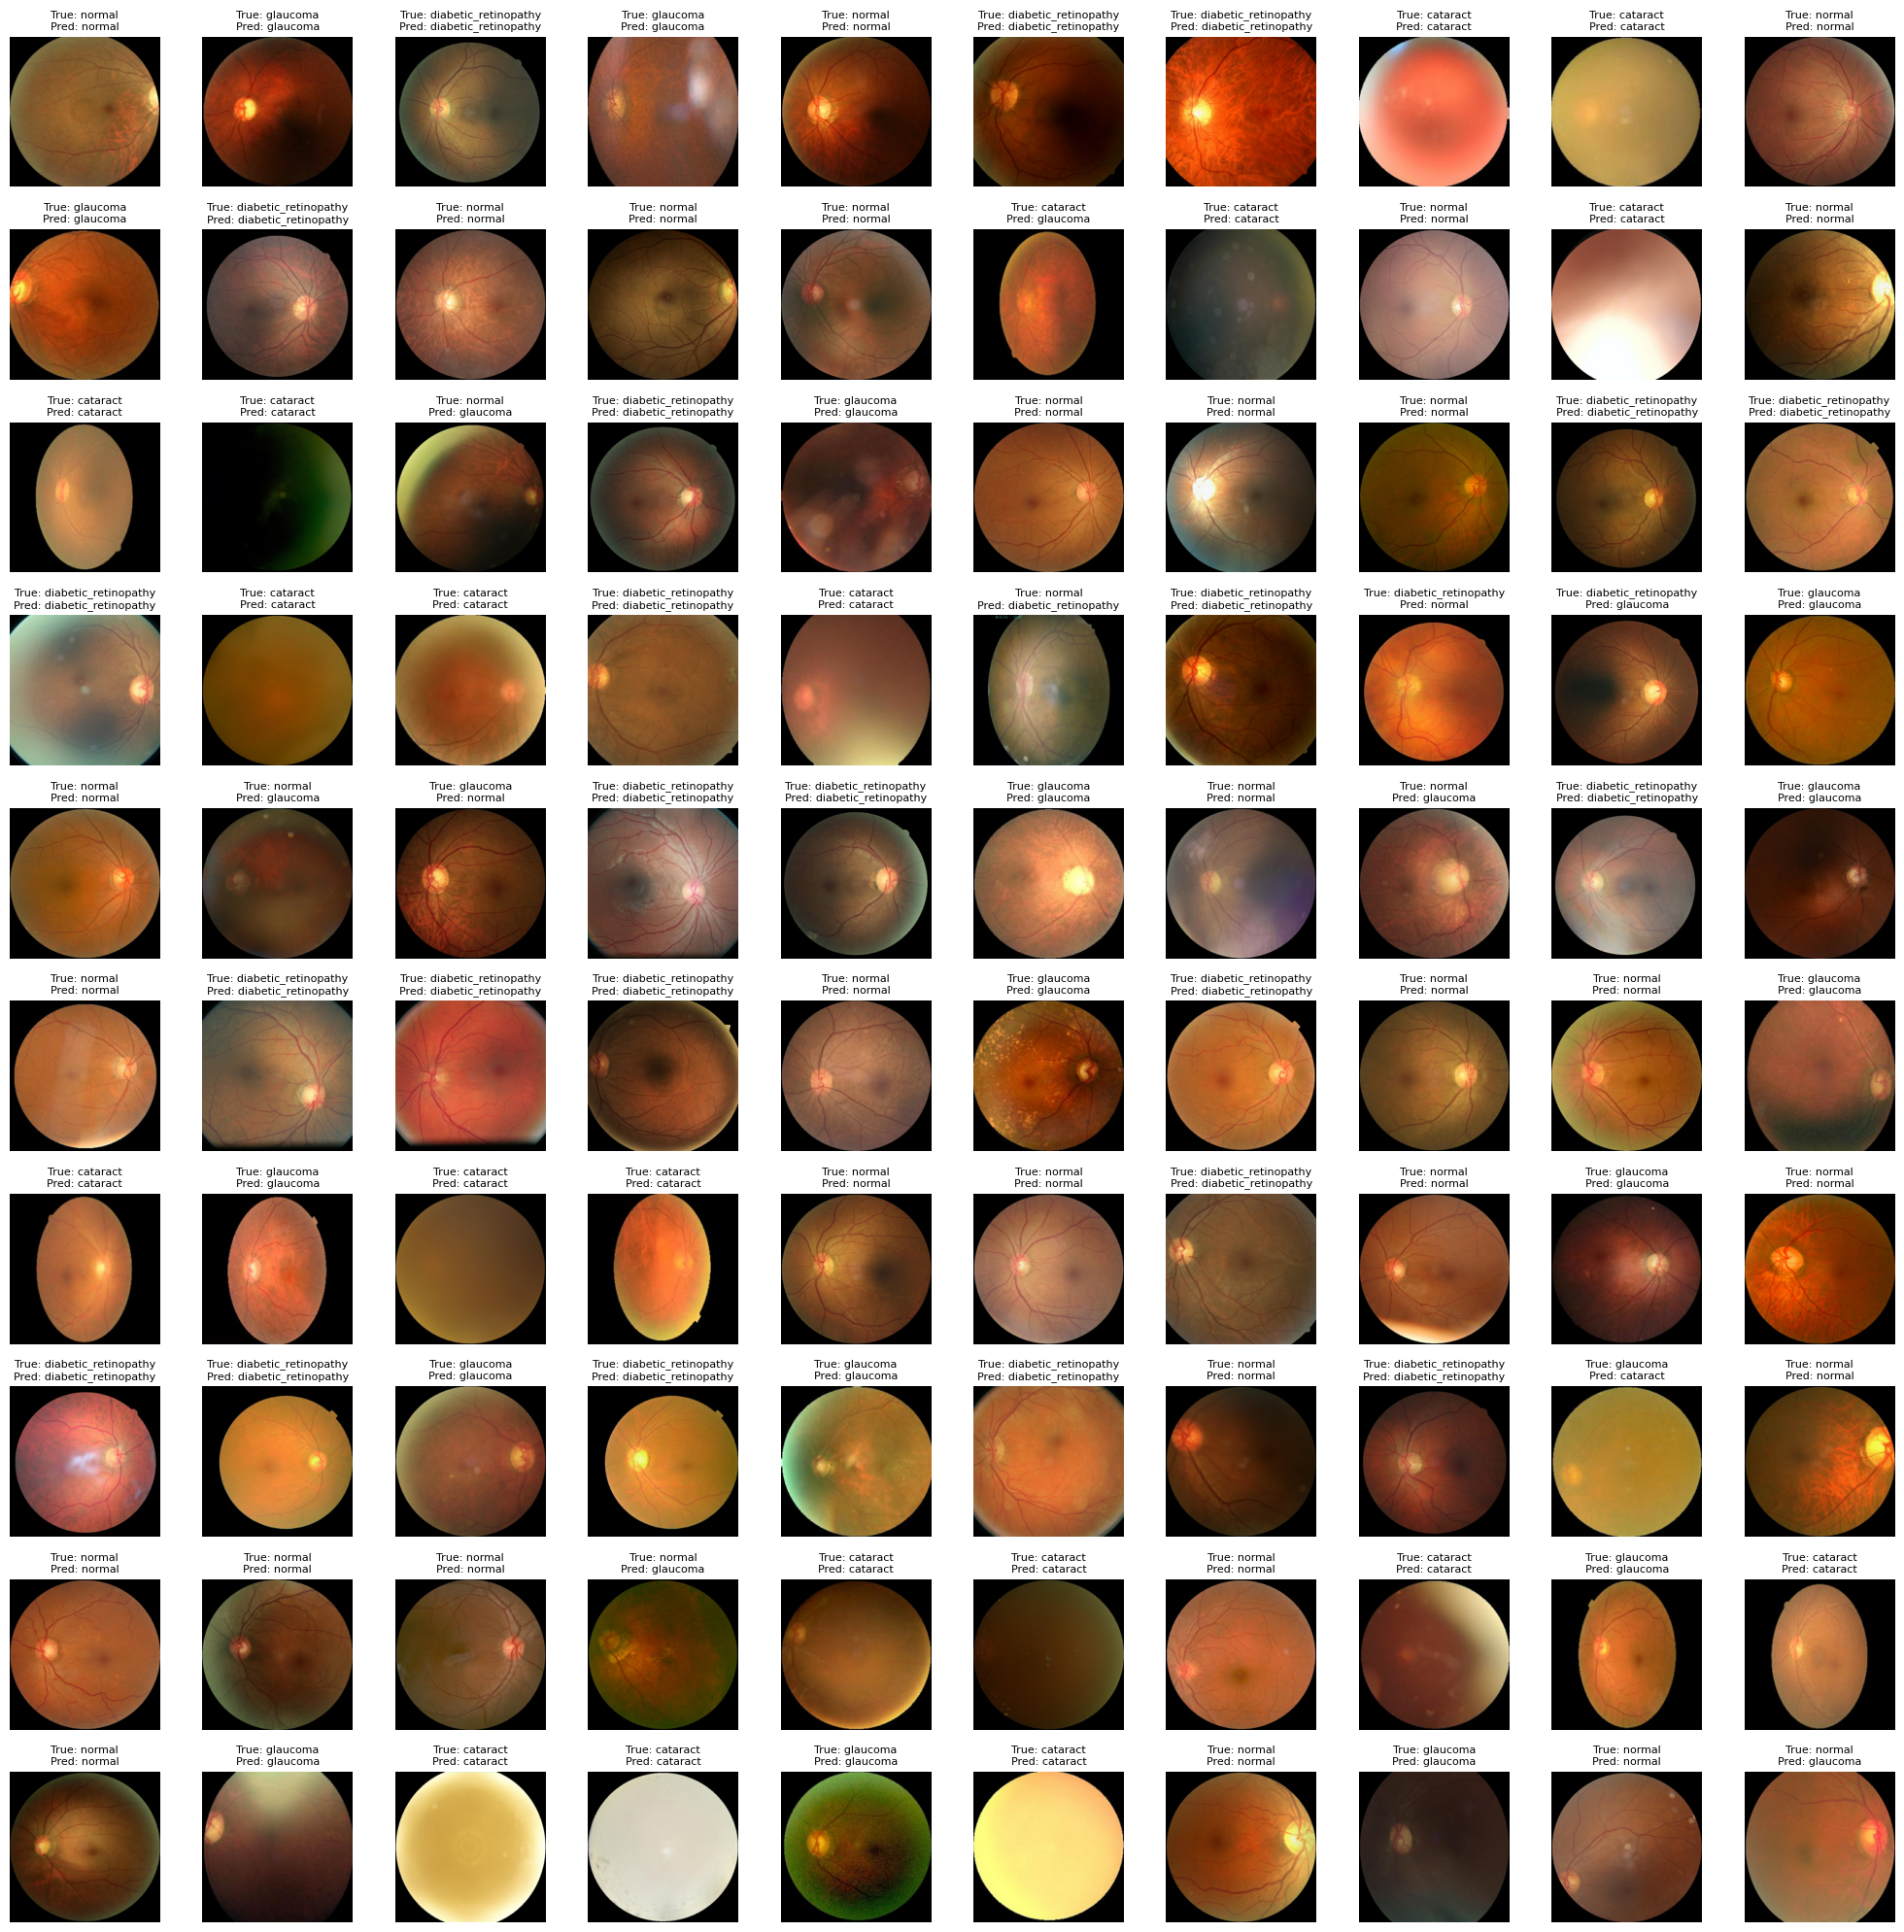

In [56]:
# Figure using Matplotlib

import matplotlib.pyplot as plt

# --- Helper to ensure uint8 ---
def to_uint8(img):
    arr = np.asarray(img)
    if arr.dtype == np.uint8:
        return arr
    if np.issubdtype(arr.dtype, np.floating) and arr.max() <= 1.0:
        arr = (np.clip(arr, 0.0, 1.0) * 255).astype(np.uint8)
    else:
        arr = np.clip(arr, 0, 255).astype(np.uint8)
    return arr

# --- Setup Data ---
df = Test_Results_df.head(100)
n = len(df)
grid = int(np.ceil(np.sqrt(n)))

# --- Create Matplotlib Figure ---
fig, axes = plt.subplots(grid, grid, figsize=(grid * 2, grid * 2))
axes = axes.flatten()   # flatten for easy indexing

for idx, (i, row) in enumerate(df.iterrows()):
    ax = axes[idx]
    img = to_uint8(row["Image_Data"])
    ax.imshow(img)
    ax.set_title(
        f"True: {row['True_Label']}\nPred: {row['Prediction_Label']}",
        fontsize=8
    )
    ax.axis("off")

# Turn off any extra empty subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


# Test-Set Performance Evaluation

Your model is a 4-class image classifier for **cataracts**, **diabetic retinopathy**, **glaucoma**, and **normal** retinal images.  
Below is a structured interpretation of your test metrics.

---

## Overall Metrics
- **Loss:** `0.3305`  
- **Accuracy:** `0.8873`  
- **Macro F1 Score:** `0.8840`

**Interpretation:**  
These are strong results for a 4-class medical image classification task. Accuracy near 0.89 is well above the 25% random baseline, and an F1 around 0.88 indicates balanced and reliable predictions across classes.

---

## Per-Class Precision

| Class | Precision | Notes |
|-------|-----------|-------|
| **Cataract** | `0.9102` | Very strong; few false positives. |
| **Diabetic Retinopathy** | `0.9727` | Excellent; highly reliable predictions. |
| **Glaucoma** | `0.8161` | Weaker; more false positives. |
| **Normal** | `0.8865` | Very good performance. |

**Summary:**  
Precision is strong overall, especially for diabetic retinopathy. Glaucoma is the only class showing moderate precision.

---

## Per-Class Recall

| Class | Recall | Notes |
|-------|--------|-------|
| **Cataract** | `0.8889` | High sensitivity. |
| **Diabetic Retinopathy** | `0.9596` | Outstanding recall. |
| **Glaucoma** | `0.8023` | Lowest recall; misses some glaucoma cases. |
| **Normal** | `0.8286` | Good, but could be improved. |

**Summary:**  
Recall is consistently high, but glaucoma remains the most challenging class.

---

## High-Level Assessment
- **Performance is robust and clinically meaningful.**
- The model reliably identifies all classes, especially diabetic retinopathy.
- **Glaucoma** shows the weakest performance (expected due to subtle features).
- No sign of extreme class imbalance or overfitting based on metrics alone.


---

## Summary
The model demonstrates **strong overall performance** with **Accuracy ~88.7%** and **Macro F1 ~88.4%**, delivering reliable detection across all four eye-condition classes.  
Minor weaknesses in glaucoma detection are expected and can be improved with targeted techniques.

---
